In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
system_df = pd.read_csv("System Data")

<AxesSubplot:xlabel='monthly consumption', ylabel='original cost'>

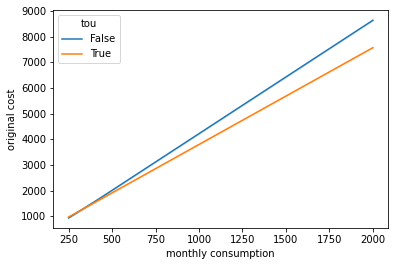

In [3]:
sns.lineplot(data=system_df, x="monthly consumption", y="original cost", hue="tou")

-0.12363859337597473

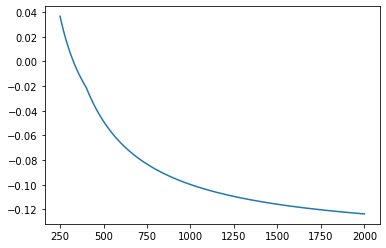

In [75]:
tou_cost = (
    system_df[system_df["tou"] == True][["monthly consumption", "original cost"]]
    .sort_values(by=["monthly consumption"], ascending=True)
    .reset_index()
)
no_tou_cost = (
    system_df[system_df["tou"] == False][["monthly consumption", "original cost"]]
    .sort_values(by=["monthly consumption"], ascending=True)
    .reset_index()
)

change = (tou_cost["original cost"] - no_tou_cost["original cost"]) / no_tou_cost[
    "original cost"
]
plt.plot(tou_cost["monthly consumption"], change)
np.min(change)

TOU is generally better (finally around 12.4% cheaper)

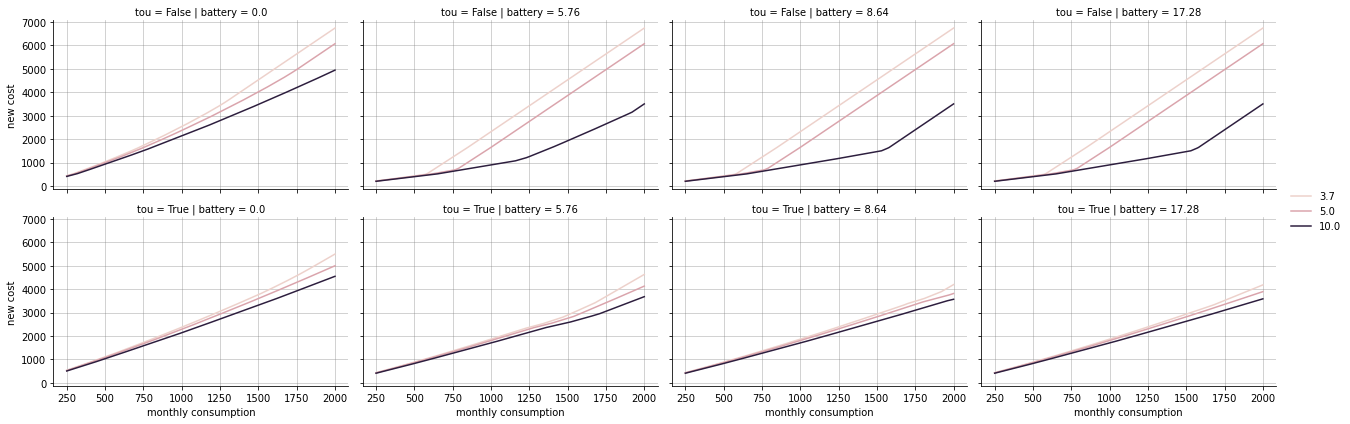

In [81]:
solar_tou_comparison_graph = sns.FacetGrid(data=system_df, row="tou", col="battery", aspect=1.5)
solar_tou_comparison_graph.map(sns.lineplot, "monthly consumption", "new cost", "capacity")
solar_tou_comparison_graph.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
solar_tou_comparison_graph.add_legend()

# for ax, (index, value) in zip(graph1.axes.flat, graph1.facet_data()):
#     if index[0] == 0 and index[1] >= 1:
#         ax.axvline(x=2500, color=colormap(0 / 3), linestyle="--")
#     if index[0] == 0 and index[1] >= 1:
#         ax.axvline(x=3400, color=colormap(1 / 3), linestyle="--")
#     if index[0] == 0 and index[1] >= 2:
#         ax.axvline(x=6900, color=colormap(2 / 3), linestyle="--")
#     if index[0] == 0 and index[1] == 0:
#         ax.axvline(x=5500, color=colormap(0 / 3), linestyle="--")
#         ax.axvline(x=7500, color=colormap(1 / 3), linestyle="--")
print()

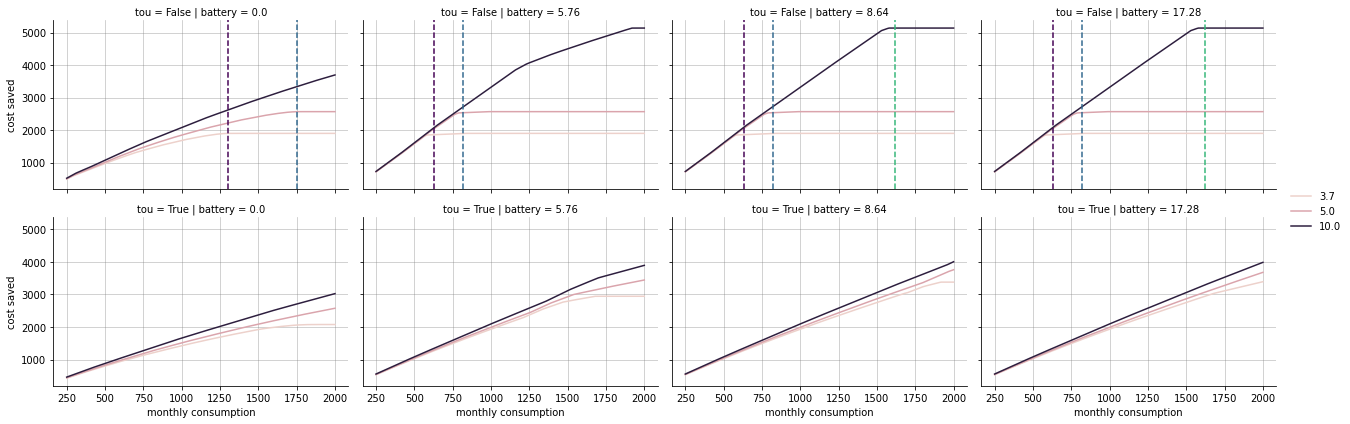

In [84]:
colormap = plt.cm.viridis

graph1 = sns.FacetGrid(data=system_df, row="tou", col="battery", aspect=1.5)
graph1.map(sns.lineplot, "monthly consumption", "cost saved", "capacity")
graph1.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph1.add_legend()

for ax, (index, value) in zip(graph1.axes.flat, graph1.facet_data()):
    if index[0] == 0 and index[1] >= 1:
        ax.axvline(x=630, color=colormap(0/3), linestyle="--")
    if index[0] == 0 and index[1] >= 1:
        ax.axvline(x=820, color=colormap(1/3), linestyle="--")
    if index[0] == 0 and index[1] >= 2:
        ax.axvline(x=1620, color=colormap(2/3), linestyle="--")
    if index[0] == 0 and index[1] == 0:
        ax.axvline(x=1300, color=colormap(0/3), linestyle="--")
        ax.axvline(x=1750, color=colormap(1/3), linestyle="--")
print()

- No battery
	- Save more money when not using TOU
	- Marginal difference between different capacity, so using 3kW is probably the best
- With battery
	- Having PV is clearly better
	- Having no TOU is clearly better
	- No TOU
		- Higher battery than 5.76 kWh does not make a big difference
		- 3kW is suitable for monthly consumption less than 2,400 THB
		- 5kW is suitable for monthly consumption between 2,400 - 3,200 THB
		- 10kW is suitable for monthly consumption of more than 3,200 THB
	- With TOU
		- Barely any difference between 3kW, 5kW & 10kW, so 3kW is probably better
		- Barely any difference between different battery capacities, so 5.78 kWh is probably better
        

In [25]:
lifespan = 15

def check_case1(row, capacity, battery):
    case1 = (
        (row["capacity"] == capacity) & (row["battery"] == battery) & (row["tou"] == False)
    )
    return case1


def check_case2(row, capacity, battery):
    case2 = (
        (row["capacity"] == capacity) & (row["battery"] == 0) & (row["tou"] == False)
    )
    return case2


def check_case3(row, capacity, battery):
    case3 = (
        (row["capacity"] == capacity)
        & (row["battery"] == battery)
        & (row["tou"] == True)
    )
    return case3


def check_case4(row, capacity, battery):
    case4 = (
        (row["capacity"] == capacity) & (row["battery"] == 0) & (row["tou"] == True)
    )
    return case4


def check_case(row, setup_capacity, setup_battery):
    if check_case1(row, setup_capacity, setup_battery):
        return 1
    if check_case2(row, setup_capacity, setup_battery):
        return 2
    if check_case3(row, setup_capacity, setup_battery):
        return 3
    if check_case4(row, setup_capacity, setup_battery):
        return 4
    return 0


def check_scenario(row):
    capacity_list = [3.7, 5, 10]
    battery_list = [5.76, 5.76, 8.64]
    setup_id_list = list(range(1, len(capacity_list)+1))

    for setup_id, capacity, battery in zip(setup_id_list, capacity_list, battery_list):
        case = check_case(row, capacity, battery)
        if case:
            result = f"{setup_id}.{case}"
            return result
    return None


def get_setup(row):
    if not row["scenario"]:
        return None
    scenario = row["scenario"]
    setup = scenario.split(".")[0]
    return setup


def get_case(row):
    if not row["scenario"]:
        return None
    scenario = row["scenario"]
    case = scenario.split(".")[1]
    return case


def check_cost(row):
    cost_dict = {
        "1.1": 134_960.1,
        "1.2": 78_735.8,
        "1.3": 134_960.1,
        "1.4": 78_735.8,

        "2.1": 149_985.53,
        "2.2": 93_761.23,
        "2.3": 149_985.53,
        "2.4": 93_761.23,

        "3.1": 231_282.28,
        "3.2": 150_303.43,
        "3.3": 231_282.28,
        "3.4": 150_303.43,
    }
    if not row["scenario"]:
        return None
    return cost_dict[row["scenario"]]


def filter_df(df):
    temp = df.copy()

    temp["scenario"] = temp.apply(check_scenario, axis=1)
    temp = temp[temp["scenario"].notna()]

    temp["setup"] = temp.apply(get_setup, axis=1)
    temp["case"] = temp.apply(get_case, axis=1)

    temp["cost"] = temp.apply(check_cost, axis=1)
    temp["payback period"] = temp["cost"] / temp["cost saved"] / 12

    temp["total earning"] = temp["cost saved"] * 12 * lifespan
    temp["net profit"] = temp["total earning"] - temp["cost"]
    temp["roi"] = temp["net profit"] / temp["cost"]
    return temp

df_filtered = filter_df(system_df)
# df_filtered

In [6]:
test = df_filtered[
    (df_filtered["monthly consumption"] == 1750)
    & (df_filtered["capacity"] == 5)
    & (df_filtered["tou"] == False)
]

test = test.sort_values(by=["scenario"], ascending=True)
test[
    [
        "scenario",
        "capacity",
        "battery",
        "monthly consumption",
        "original cost",
        "new cost",
        "cost saved",
        "cost",
        "payback period",
        "tou",
        "monthly solar energy",
        "net consumption",
        "consumption reduced",
    ]
]

,scenario,capacity,battery,monthly consumption,original cost,new cost,cost saved,cost,payback period,tou,monthly solar energy,net consumption,consumption reduced
2609,2.1,5.0,5.76,1750,7536.625,4967.971036,2568.653964,149985.53,4.865893,False,580.92,1169.080000,580.920000
2608,2.2,5.0,0.00,1750,7536.625,4969.125595,2567.499405,93761.23,3.043208,False,580.92,1169.341112,580.658888


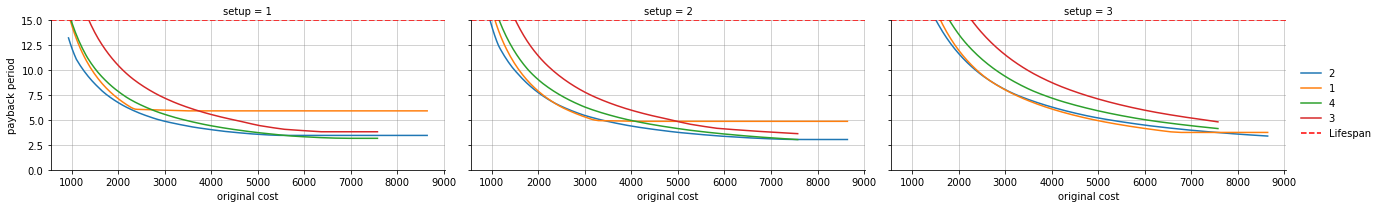

In [7]:
graph2 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph2.map(sns.lineplot, "original cost", "payback period", "case")
graph2.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph2.map(plt.axhline, y=lifespan, color="r", linestyle="--", label="Lifespan")
graph2.set(ylim=(0, 15))
graph2.add_legend()

We should aim for Payback period of 7 years

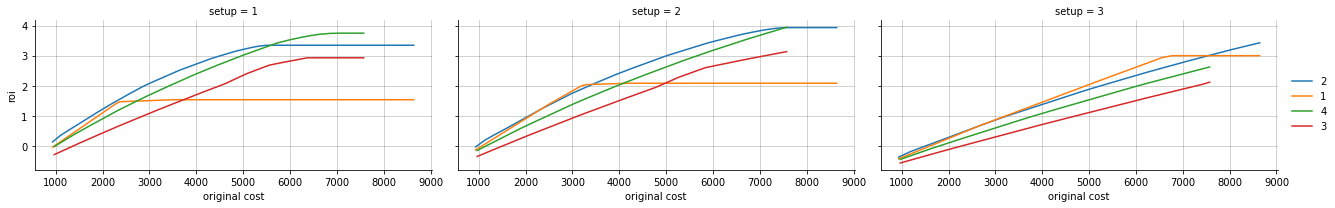

In [8]:
graph3 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph3.map(sns.lineplot, "original cost", "roi", "case")
graph3.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph3.add_legend()

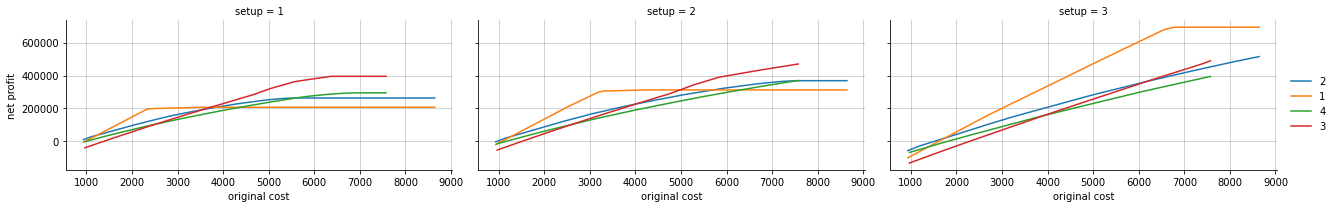

In [9]:
graph4 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph4.map(sns.lineplot, "original cost", "net profit", "case")
graph4.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph4.add_legend()

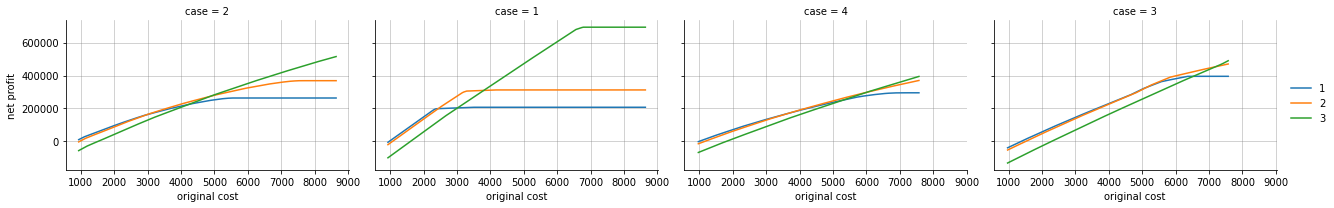

In [11]:
graph5 = sns.FacetGrid(data=df_filtered, col="case", aspect= 1.5)
graph5.map(sns.lineplot, "original cost", "net profit", "setup")
graph5.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph5.add_legend()

In [14]:
"z" in ["i", "a"]

False

<AxesSubplot:xlabel='original cost', ylabel='roi'>

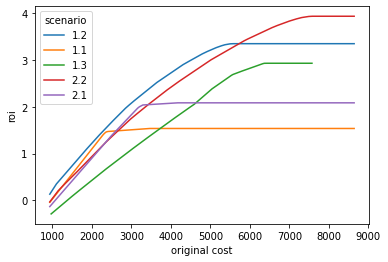

In [21]:
sample = df_filtered[df_filtered["scenario"].isin(["1.1", "1.2", "1.3", "2.1", "2.2"])]
sns.lineplot(sample, x="original cost", y="roi", hue="scenario")

<AxesSubplot:xlabel='original cost', ylabel='net profit'>

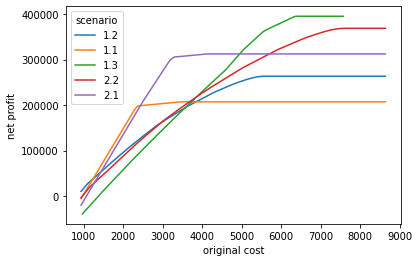

In [24]:
sample = df_filtered[df_filtered["scenario"].isin(["1.1", "1.2", "1.3", "2.1", "2.2"])]
sns.lineplot(sample, x="original cost", y="net profit", hue="scenario")